In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')
sc.settings.set_figure_params(dpi=300)  # low dpi (dots per inch) yields small inline figures
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, frameon=False, facecolor='white')  # figsize=(3, 3), low dpi (dots per inch) yields small inline figures

Global seed set to 0


In [3]:
from cell2location.models import RegressionModel

## File names and folders 

In [2]:
results_folder = '/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_allsubCT'

## Load the scRNA-seq data 

In [6]:
## scRNA reference (raw counts)
adata_sc = anndata.read_h5ad("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_allsubCT/scRNAseq_allcleanCells.h5ad")

In [10]:
adata_sc

AnnData object with n_obs × n_vars = 58823 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'doublet_scores', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'newCellTypes', 'newMainCellTypes', 'upCellTypes'
    var: '_index', 'features'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [12]:
adata_sc.raw.var

,_index
0,RP11-34P13.7
1,RP11-34P13.13
2,RP11-34P13.9
3,RP11-206L10.4
4,LINC01409
...,...
25773,LINC02169
25774,ELSPBP1
25775,LINC01258
25776,LINC02492


In [14]:
adata_sc.obsm

AxisArrays with keys: X_harmony, X_pca, X_umap

In [13]:
adata_sc.obs

,orig.ident,nCount_RNA,nFeature_RNA,Patient,Gender,Age,Condition,Doublet,doublet_scores,percent.mt,percent.ribo,percent.hb,percent.malat1,S.Score,G2M.Score,Phase,CC.Difference,newCellTypes,newMainCellTypes,upCellTypes
PWH26D0_AAACCCACACGTAACT-1,PWH26D0,27681.0,5164,PWH26,Male,29.0,Skin,Singlet,0.015007,5.447562,32.745491,0.0,2.097528,-0.024170,0.016767,G2M,-0.040937,Spi-II,Keratinocyte,Spi_II_a
PWH26D0_AAACCCACACTGAGGA-1,PWH26D0,17228.0,3981,PWH26,Male,29.0,Skin,Singlet,0.022768,7.936756,37.161284,0.0,2.460082,0.002494,0.025756,G2M,-0.023262,Spi-I,Keratinocyte,Spi_I
PWH26D0_AAACCCAGTCCGACGT-1,PWH26D0,19962.0,3928,PWH26,Male,29.0,Skin,Singlet,0.033618,6.533741,42.505817,0.0,2.386275,0.022022,-0.022383,S,0.044405,Spi-I,Keratinocyte,Spi_II_a
PWH26D0_AAACCCATCAGCGGAA-1,PWH26D0,19153.0,4177,PWH26,Male,29.0,Skin,Singlet,0.016827,5.637100,36.548496,0.0,0.965524,-0.027139,-0.047936,G1,0.020797,Spi-I,Keratinocyte,Spi_I
PWH26D0_AAACGAAAGGATAATC-1,PWH26D0,6505.0,1850,PWH26,Male,29.0,Skin,Singlet,0.008850,0.507393,33.444477,0.0,5.189910,0.020565,-0.041541,S,0.062106,Th,Lymphoid,ILCs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PWH28D7_TTTGTTGCAACCCTCT-1,PWH28D7,7784.0,2078,PWH28,Male,24.0,Wound7,Singlet,0.014063,5.609443,39.301157,0.0,3.424097,-0.051614,-0.084194,G1,0.032581,Th,Lymphoid,ILCs
PWH28D7_TTTGTTGGTAGCGTAG-1,PWH28D7,18123.0,4357,PWH28,Male,24.0,Wound7,Singlet,0.072561,10.283789,9.714313,0.0,3.711086,-0.144679,-0.151745,G1,0.007066,Gra-I,Keratinocyte,Gra_I
PWH28D7_TTTGTTGGTTGGGAAC-1,PWH28D7,33583.0,5652,PWH28,Male,24.0,Wound7,Singlet,0.321937,2.574185,17.040536,0.0,2.427088,0.027696,-0.077565,S,0.105261,FB-III,Fibroblast,FB_III_ELN_LEPR
PWH28D7_TTTGTTGTCGACATTG-1,PWH28D7,10669.0,3478,PWH28,Male,24.0,Wound7,Singlet,0.015099,3.036437,19.089949,0.0,3.062841,-0.101196,-0.095700,G1,-0.005496,VE,Endothelial,VE_venule2


In [15]:
adata_sc.var

,_index,features
0,RP11-34P13.7,RP11-34P13.7
1,RP11-34P13.13,RP11-34P13.13
2,RP11-34P13.9,RP11-34P13.9
3,RP11-206L10.4,RP11-206L10.4
4,LINC01409,LINC01409
...,...,...
25773,LINC02169,LINC02169
25774,ELSPBP1,ELSPBP1
25775,LINC01258,LINC01258
25776,LINC02492,LINC02492


In [19]:
# OBS! The raw matrix has numericals instead of gene names as var.index, also make sure column name is correct!
adata_sc.raw.var.rename(columns = {'_index':'features'}, inplace = True)
adata_sc.raw.var.index = adata_sc.var.index

In [20]:
adata_sc.var.index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '25768', '25769', '25770', '25771', '25772', '25773', '25774', '25775',
       '25776', '25777'],
      dtype='object', length=25778)

In [17]:
# OBS! The raw matrix has numericals instead of gene names as var.index, also make sure column name is correct!
adata_sc.raw.var.rename(columns = {'_index':'features'}, inplace = True)
adata_sc.raw.var.index = adata_sc.var.index
adata_sc = adata_sc.raw.to_adata()

In [18]:
adata_sc.var.index = adata_sc.var['features']

In [19]:
adata_sc

AnnData object with n_obs × n_vars = 56063 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'CellTypes', 'newCellTypes', 'newMainCellTypes', 'newAnnoNum', 'doublet_scores', 'upCellTypes'
    var: 'features'

In [20]:
type(adata_sc)

anndata._core.anndata.AnnData

In [21]:
adata_sc.obs[["upCellTypes"]].value_counts()

upCellTypes       
Spi_II_a              6290
Bas_I                 5559
Spi_mig               4558
Spi_I                 3415
FB_I_POSTN_COL11A1    3399
Spi_II_b              3219
FB_III_ELN_LEPR       2008
Bas_prolif            1933
FB_I_POSTN_MMP11      1846
cDC2                  1611
Hair_follicle         1459
Th                    1440
FB_II_APOD_ITM2A      1295
M2                    1081
Mac_inf               1046
VE_venule1            1042
FB_I_SFRP4_COMP       1014
Bas_mig                986
FB_II_APOE_CCL19       957
M1                     875
ILCs                   851
Gra_I                  823
MEL                    751
SMC                    710
FB_prolif              582
NK                     568
FB_ELN_SFRP4           552
ILC1_NK                542
Ttol                   516
cDC1                   506
Treg                   504
FB_I_POSTN_COL4A1      406
LE                     402
Mac_mig                398
Pericytes              385
Plasma                 365
DC3      

In [12]:
adata_sc.obs[["upCellTypes"]].value_counts()

upCellTypes         
Spi_II_a                6290
Bas_I                   5559
Spi_mig                 4558
Spi_I                   3415
FB-I(POSTN+COL11A1+)    3399
Spi_II_b                3219
FB-III(ELN+LEPR+)       2008
Bas_prolif              1933
FB-I(POSTN+MMP11+)      1846
cDC2                    1611
Hair_follicle           1459
Th                      1440
FB-II(APOD+ITM2A+)      1295
M2                      1081
Mac_inf                 1046
VE_venule1              1042
FB-I(SFRP4+COMP+)       1014
Bas_mig                  986
FB-II(APOE+CCL19+)       957
M1                       875
ILCs                     851
Gra_I                    823
MEL                      751
SMC                      710
FB-prolif                582
NK                       568
FB(ELN+SFRP4+)           552
ILC1/NK                  542
Ttol                     516
cDC1                     506
Treg                     504
FB-I(POSTN+COL4A1+)      406
LE                       402
Mac_mig               

## scRNA-seq data filtering

filtered out 2 genes that are detected in less than 1 cells


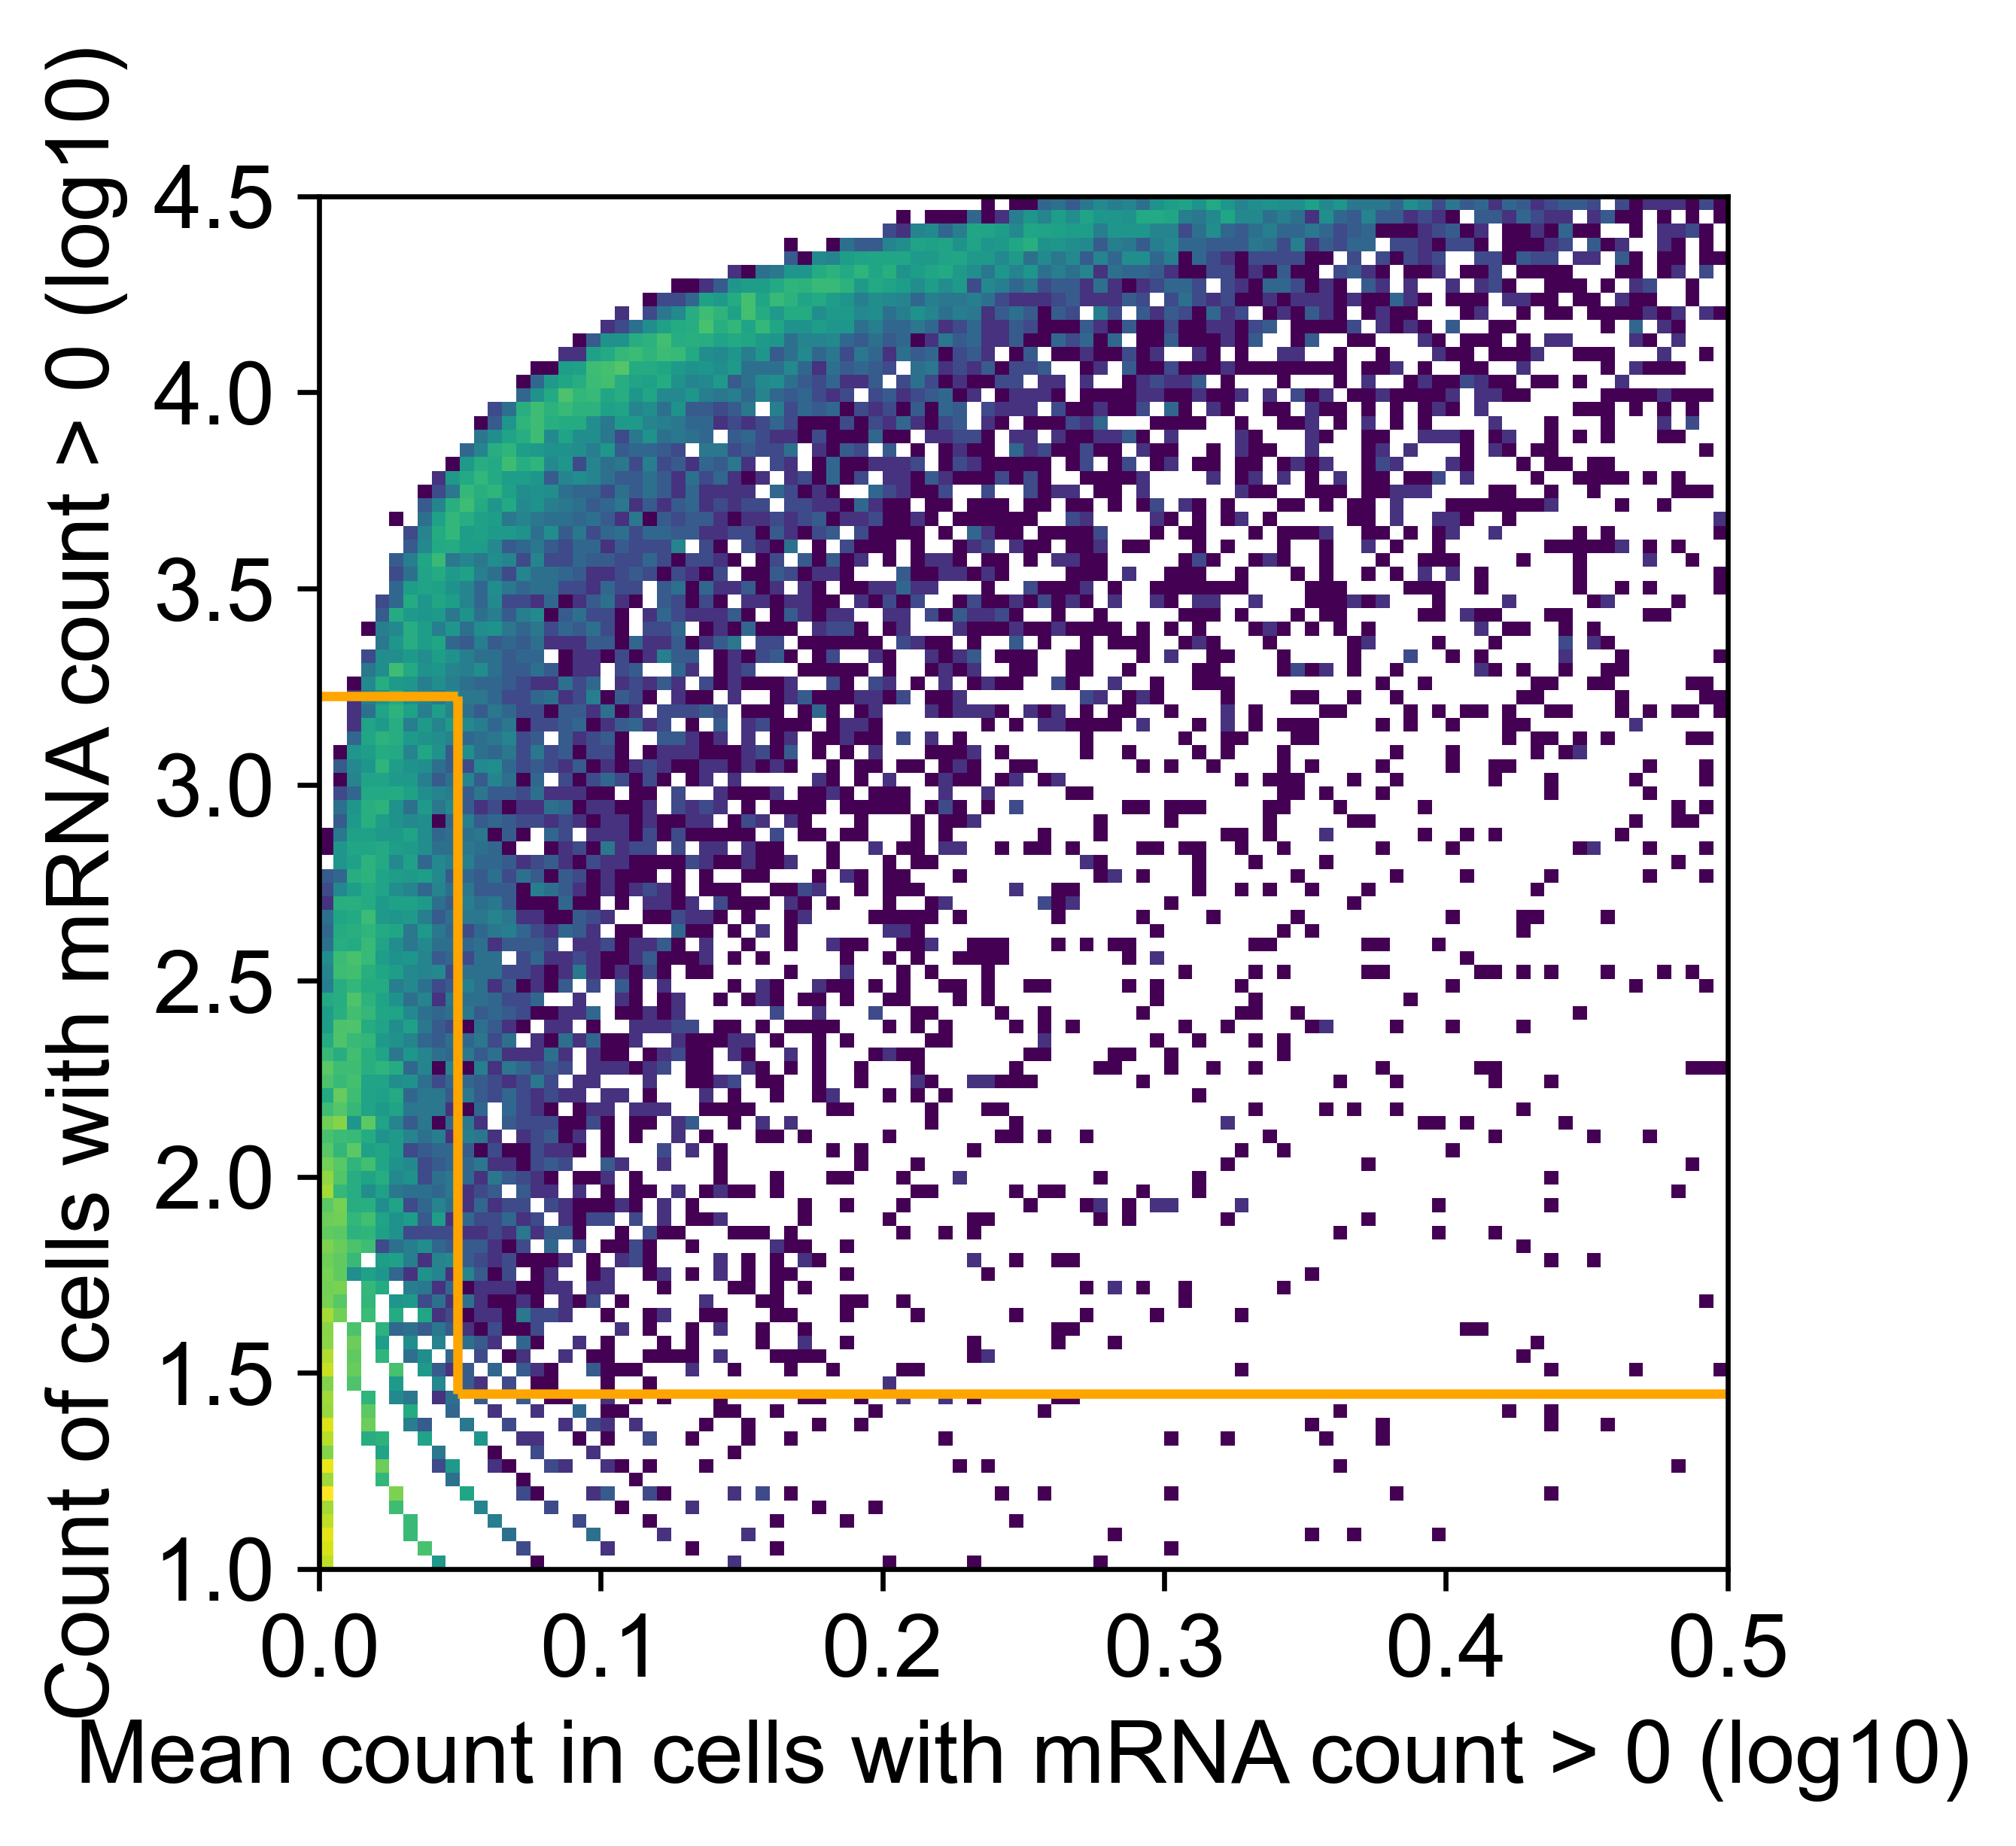

In [22]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_sc, min_genes=1)
sc.pp.filter_genes(adata_sc, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_sc.var['n_cells'] = (adata_sc.X.toarray() > 0).sum(0)
adata_sc.var['nonz_mean'] = adata_sc.X.toarray().sum(0) / adata_sc.var['n_cells']

plt.hist2d(np.log10(adata_sc.var['nonz_mean']),
           np.log10(adata_sc.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells 
cell_count_cutoff = np.log10(adata_sc.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_sc.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

In [23]:
# Show the number of selected cells and genes:
adata_sc[:,(np.array(np.log10(adata_sc.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_sc.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_sc.var['n_cells']) > cell_count_cutoff)].shape

(56063, 16522)

In [24]:
# select genes based on mean expression in non-zero cells
adata_sc = adata_sc[:,(np.array(np.log10(adata_sc.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_sc.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_sc.var['n_cells']) > cell_count_cutoff)
              & np.array(~adata_sc.var['features'].isna())]

In [25]:
adata_sc

View of AnnData object with n_obs × n_vars = 56063 × 16522
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'CellTypes', 'newCellTypes', 'newMainCellTypes', 'newAnnoNum', 'doublet_scores', 'upCellTypes', 'n_genes'
    var: 'features', 'n_cells', 'nonz_mean'

### Extract the signatures of scRNA-seq data (using DE markers top100 and tree genes top20)

In [27]:
# load the marker genes of each cell type (fc>0.5, padj<0.05)
genes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_allsubCT/scRNAseq_allcleanCells_allDEs.csv")
genes

,Gene
0,FLG
1,FLG2
2,CCL21
3,TYRP1
4,CST6
...,...
3278,SOS1
3279,SLC12A2
3280,ACE
3281,VEGFC


In [28]:
intersect = np.intersect1d(adata_sc.var_names, genes['Gene'])
adata_sc = adata_sc[:, intersect].copy()
adata_sc

AnnData object with n_obs × n_vars = 56063 × 3237
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'CellTypes', 'newCellTypes', 'newMainCellTypes', 'newAnnoNum', 'doublet_scores', 'upCellTypes', 'n_genes'
    var: 'features', 'n_cells', 'nonz_mean'

In [31]:
# Save anndata object with results
adata_sc.write("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_allsubCT/scRNAseq_allcleanCells_allDEs.h5ad")

# Perform the following steps in the UPPMAX

## Train the ref scRNA-seq data 

In [ ]:
adata_sc = anndata.read_h5ad("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/scRNAseq_9combCT_allDEs.h5ad")

In [25]:
# create and train the regression model
from cell2location.models import RegressionModel

# prepare anndata for the regression model
RegressionModel.setup_anndata(adata=adata_sc,
                              # 10X reaction / sample / batch
                              batch_key='orig.ident',
                              # cell type, covariate used for constructing signatures
                              labels_key='newMainCellTypes',
                              # multiplicative technical effects (platform, 3' vs 5', donor effect)
                              categorical_covariate_keys=None,
                              continuous_covariate_keys=None
                              )

In [26]:
mod = RegressionModel(adata_sc)

In [27]:
mod.view_anndata_setup(adata_sc)

Anndata setup with scvi-tools version 0.16.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'newMainCellTypes',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 58253 │
│          n_vars          │ 2867  │
│         n_batch          │  12   │
│         n_labels         │  10   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │  PWH26D0   │          0          │
│                         │  PWH26D1   │          1          │
│                         │  PWH26D7   │          2          │
│                         │  PWH26D30  │          3          │
│                         │  PWH27D0   │          4          │
│                         │  PWH27D1   │          5          │
│                         │  PWH27D7   │          6          │
│                         │  PWH27D30  │          7          │
│                         │  PWH28D0   │          8          │
│                         │  PWH28D1   │          9          │
│                         │  PWH28D7   │         10          │
│                         │  PWH28D30  │         11          │
└─────────────────────────┴────────────┴─────────────────────┘

                              labels State Registry                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['newMainCellTypes'] │       Endothelial        │          0          │
│                               │        Fibroblast        │          1          │
│                               │      Hair follicle       │          2          │
│                               │       Keratinocyte       │          3          │
│                               │         Lymphoid         │          4          │
│                               │           Mast           │          5          │
│                               │        Melanocyte        │          6          │
│                               │         Myeloid          │          7          │
│                               │ Pericyte & Smooth muscle │          8          │
│                               │         Schwann          │          9          │
└───────────────────────────────┴──────────────────────────┴─────────────────────┘

In [28]:
# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, # If None, defaults to np.min([round((20000 / n_cells) * 400), 400])
          batch_size=2500, 
          train_size=1, # proportion of cells in the training set (for cross-validation)
          lr=0.002) #max_epochs=250

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 250/250: 100%|███████████████████████████████████| 250/250 [53:03<00:00, 12.74s/it, v_num=1, elbo_train=1.09e+8]


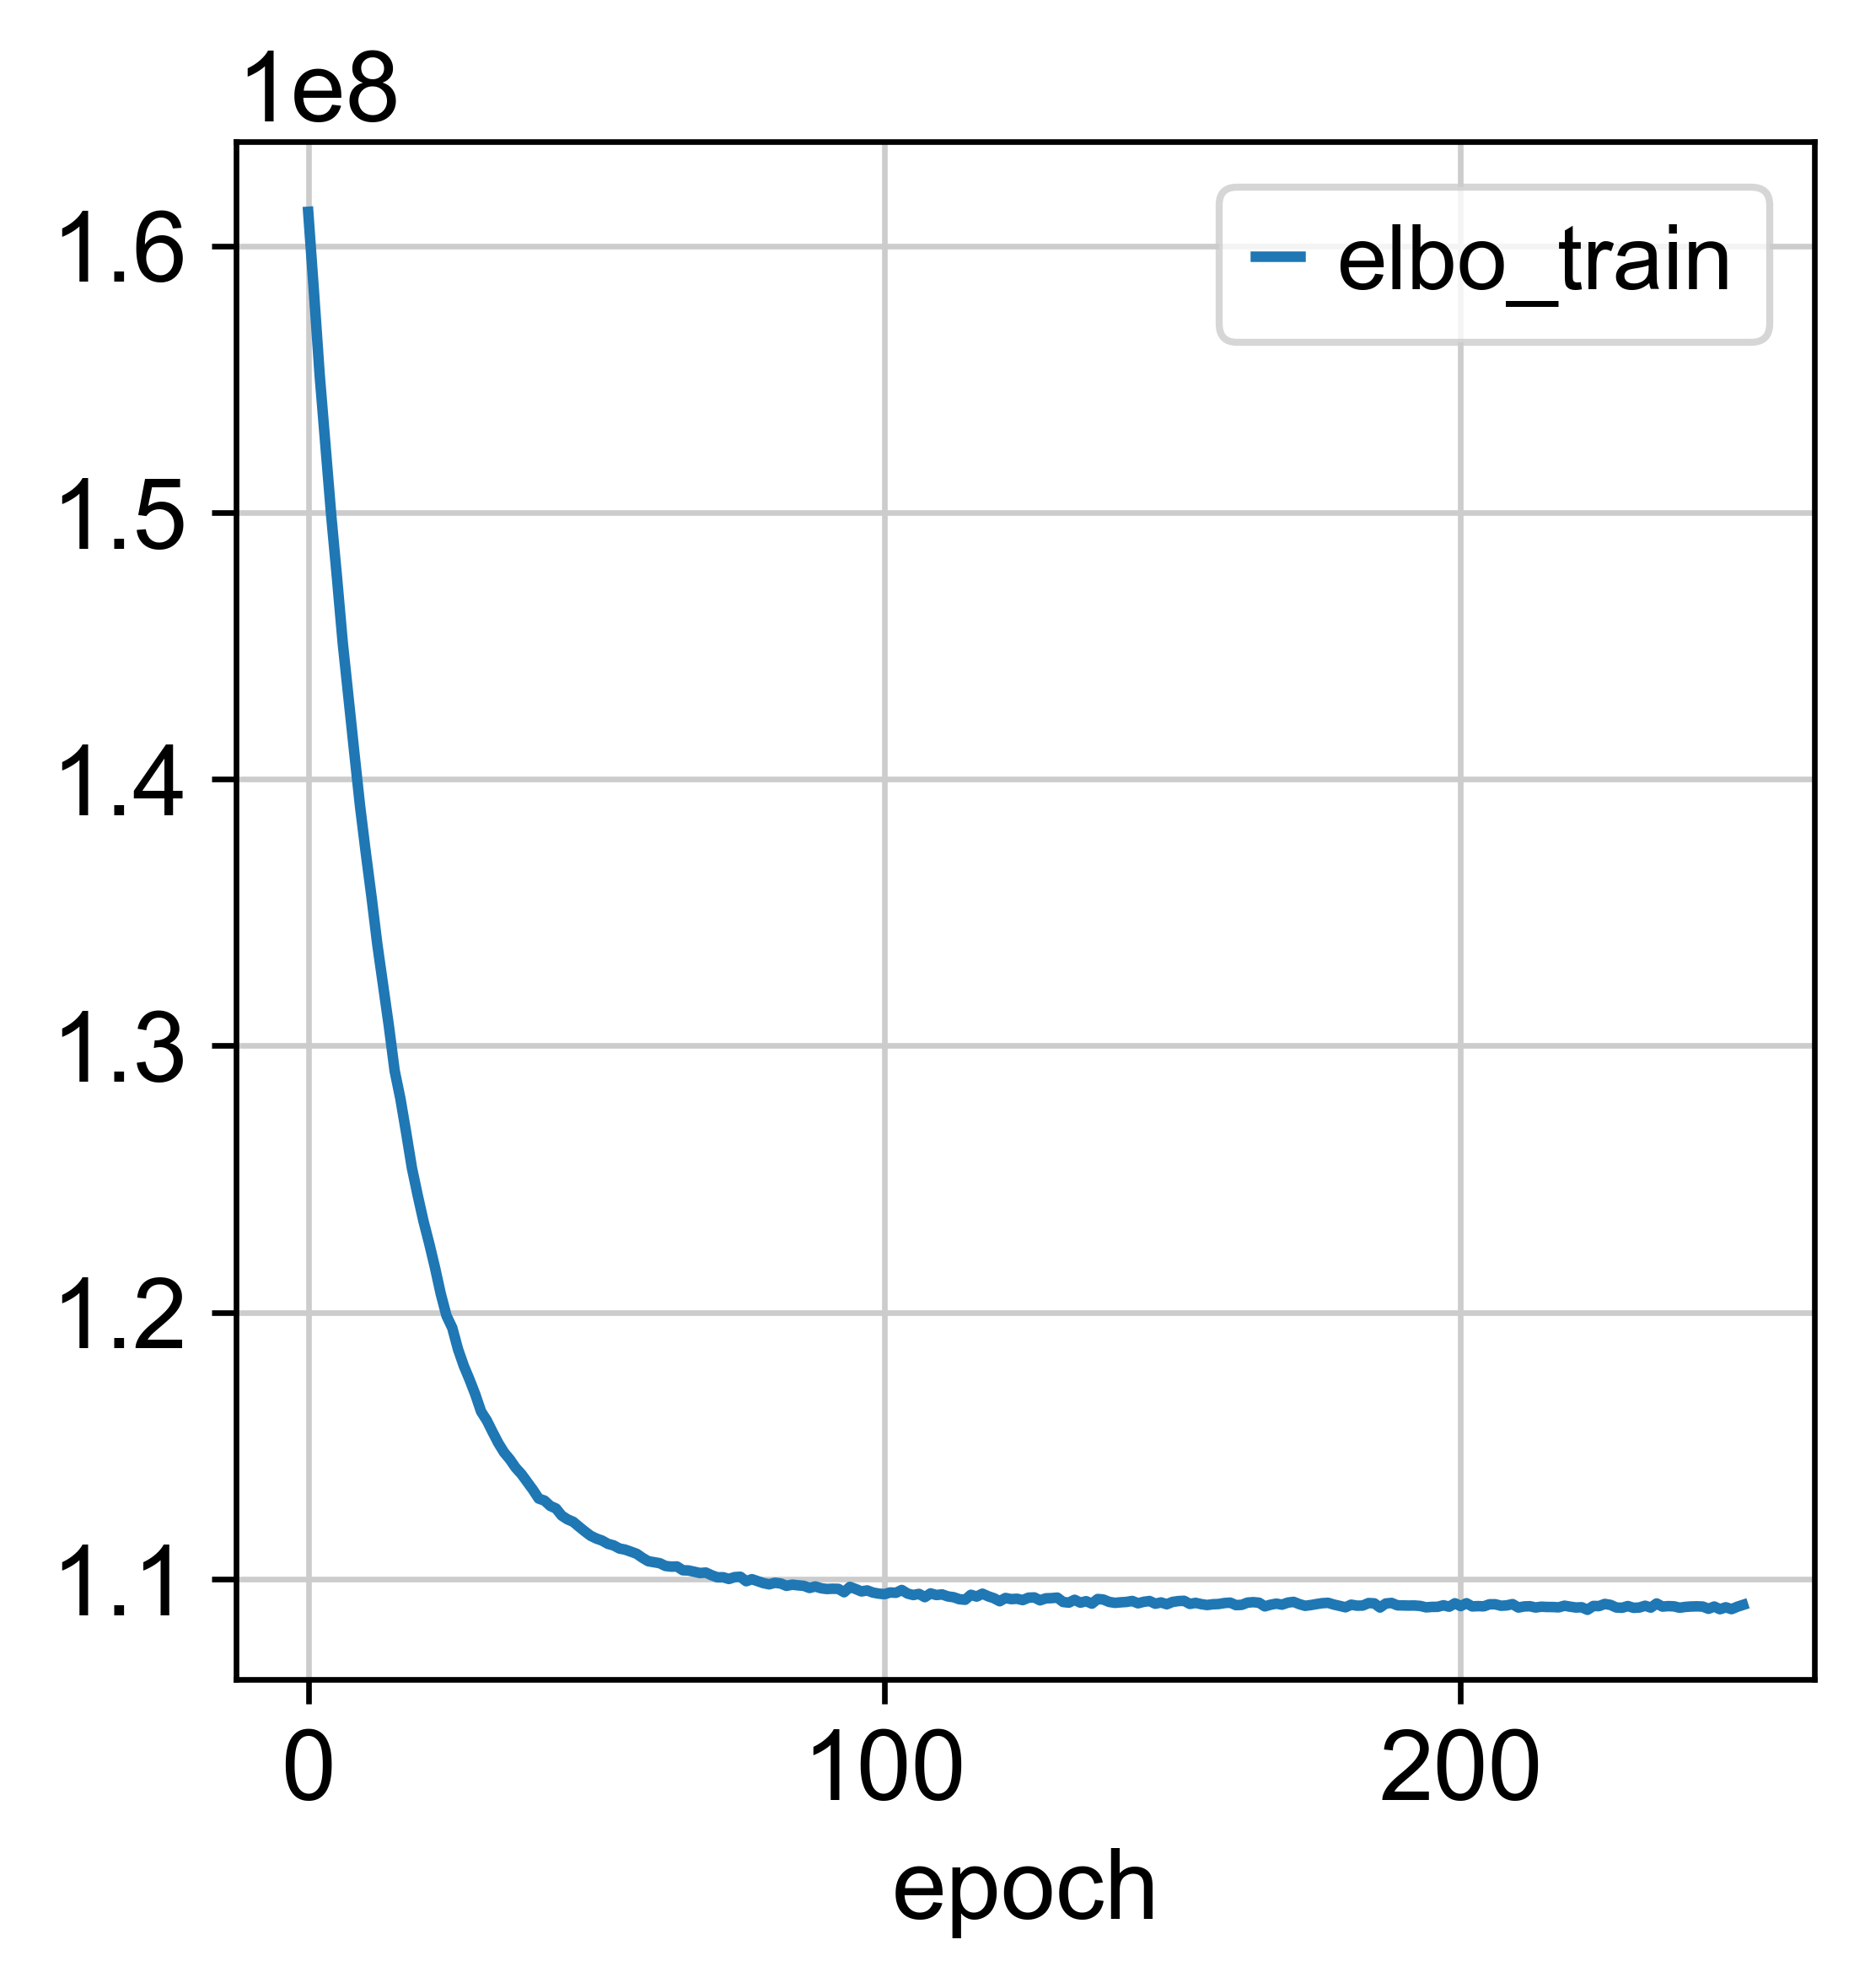

In [29]:
mod.history["elbo_train"].iloc[:].plot()
plt.show()

In [30]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_sc = mod.export_posterior(
    adata_sc, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

Sampling global variables, sample: 100%|████████████████████████████████████████████| 999/999 [00:47<00:00, 21.22it/s]


In [31]:
adata_sc

AnnData object with n_obs × n_vars = 58253 × 2867
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'CellTypes', 'newCellTypes', 'newMainCellTypes', 'doublet_scores', 'n_genes', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'features', 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    varm: 'means_per_cluster_mu_fg', 'stds_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg'

In [32]:
ref_run_name2 = f'{results_folder}/regression_model'
# Save model
mod.save(f"{ref_run_name2}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name2}/sc.h5ad"
adata_sc.write(adata_file)
adata_file

'/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/regression_model/sc.h5ad'

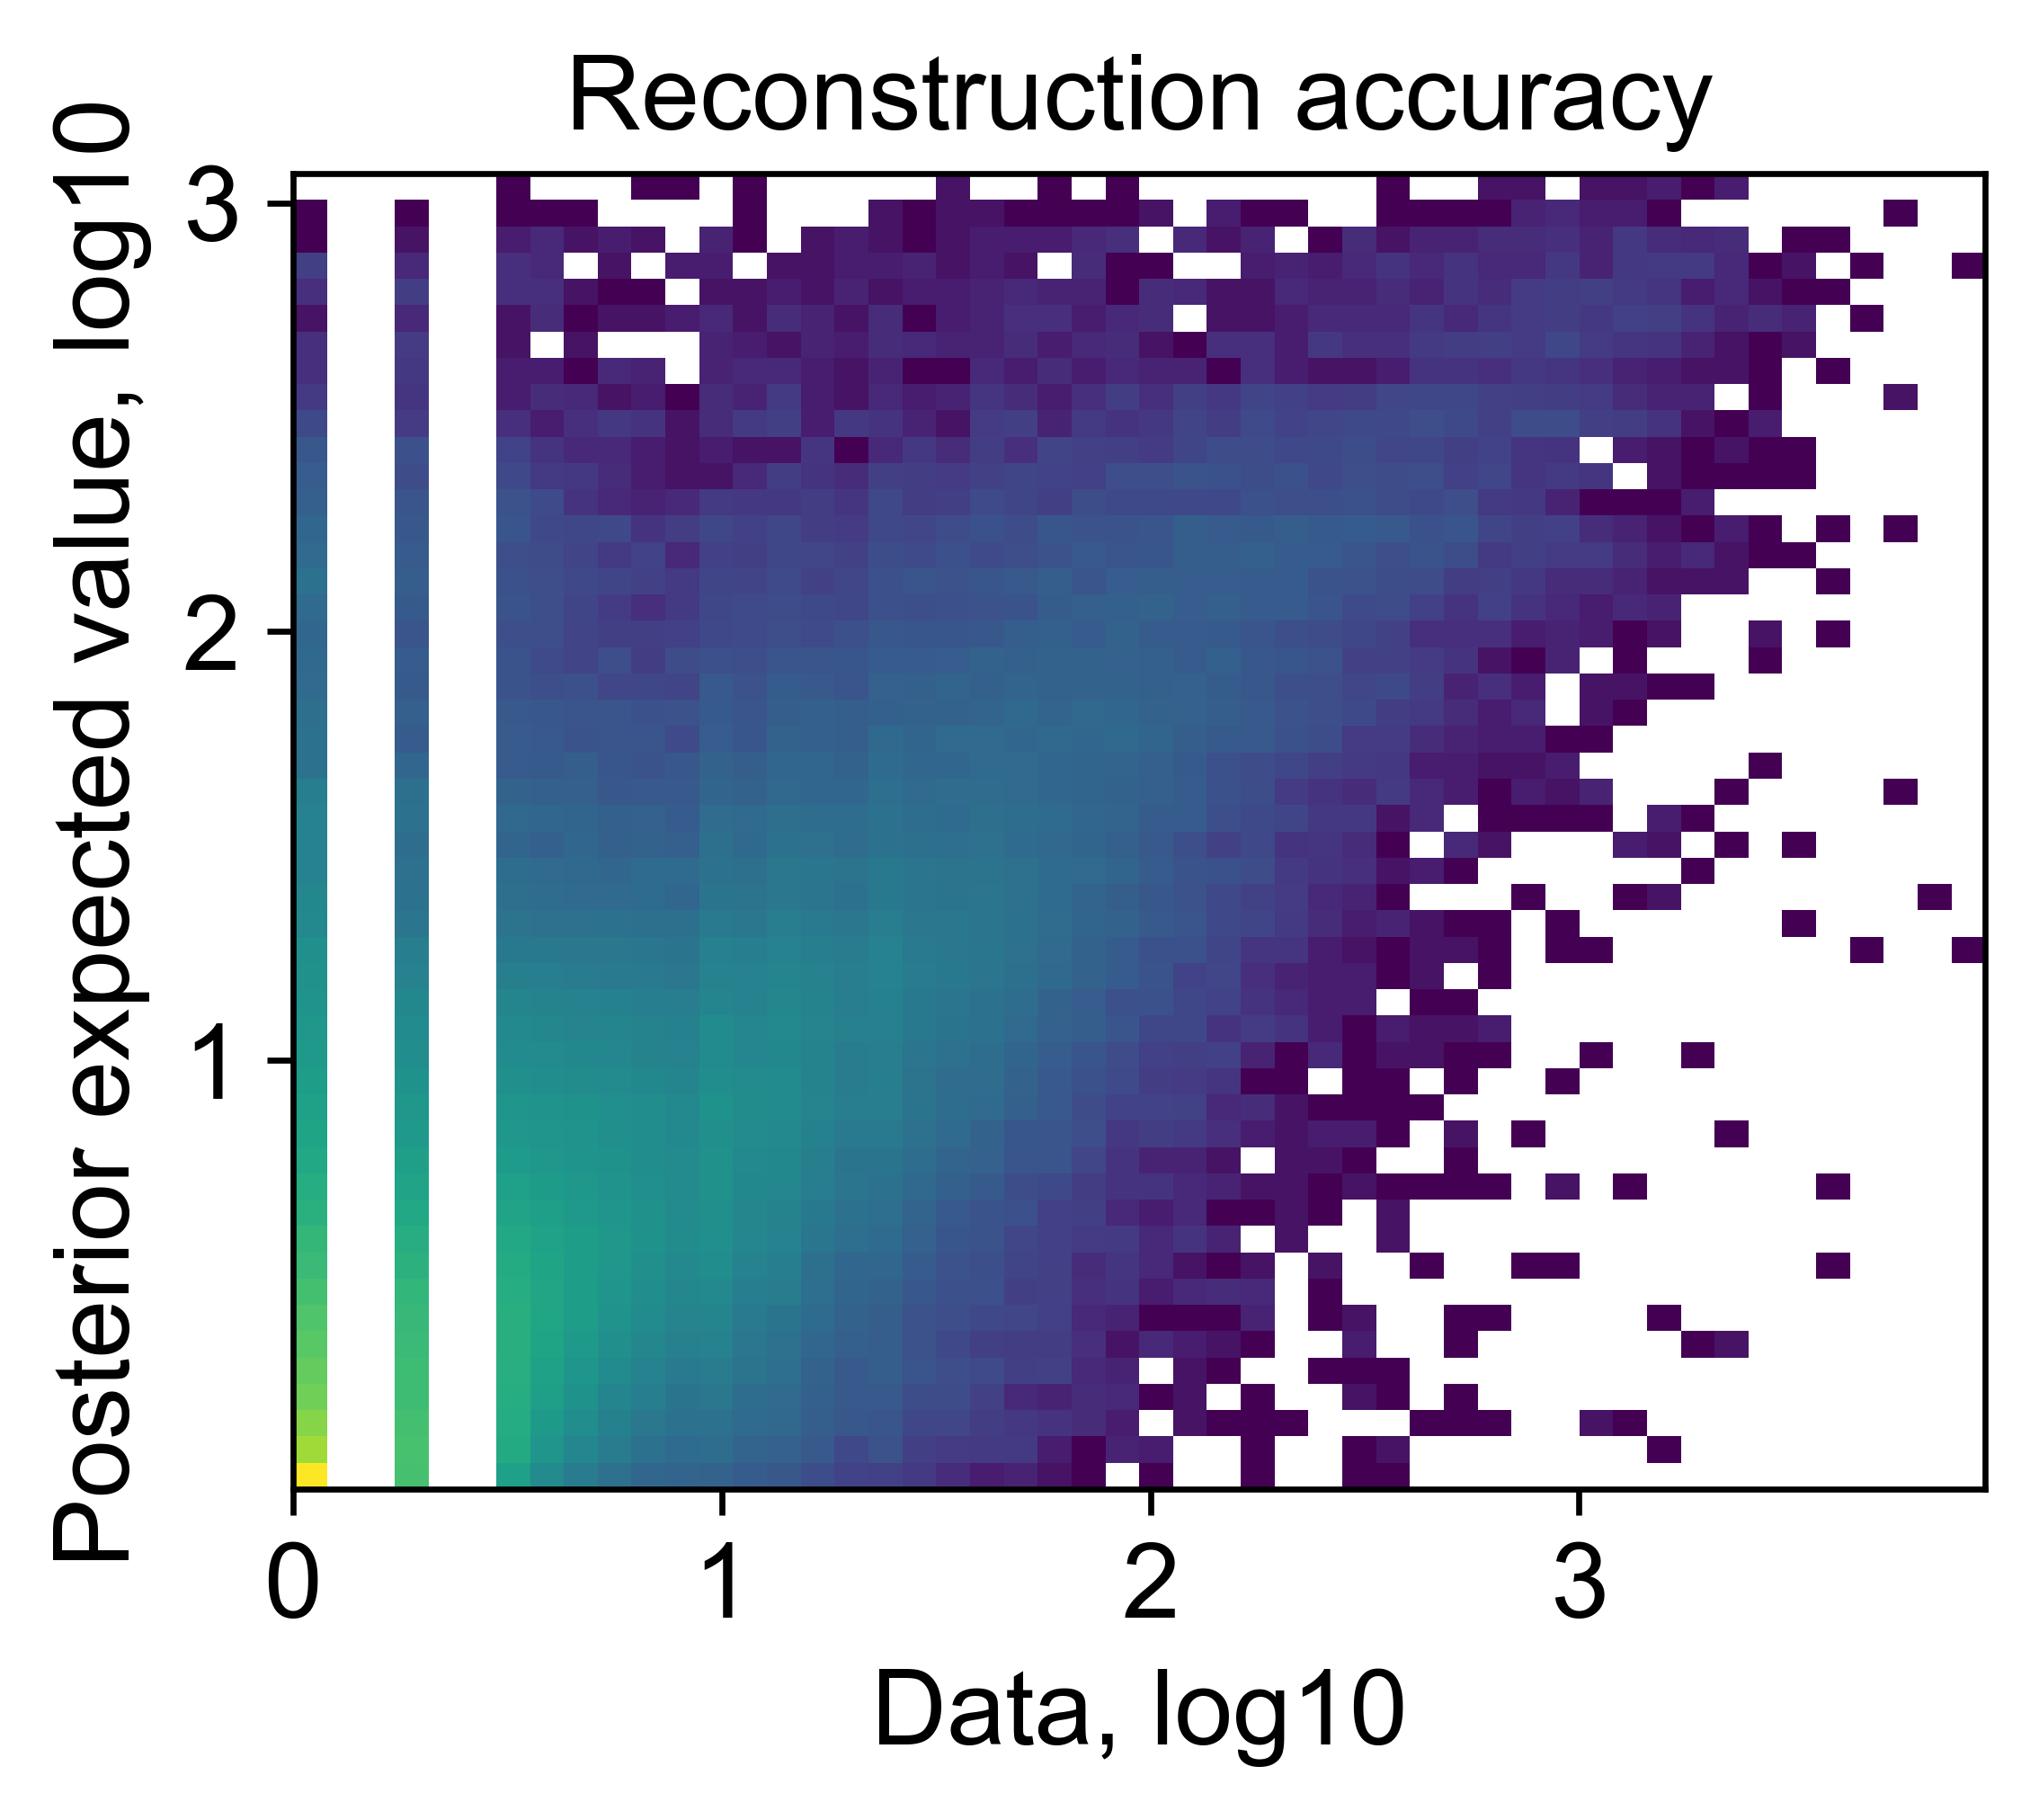

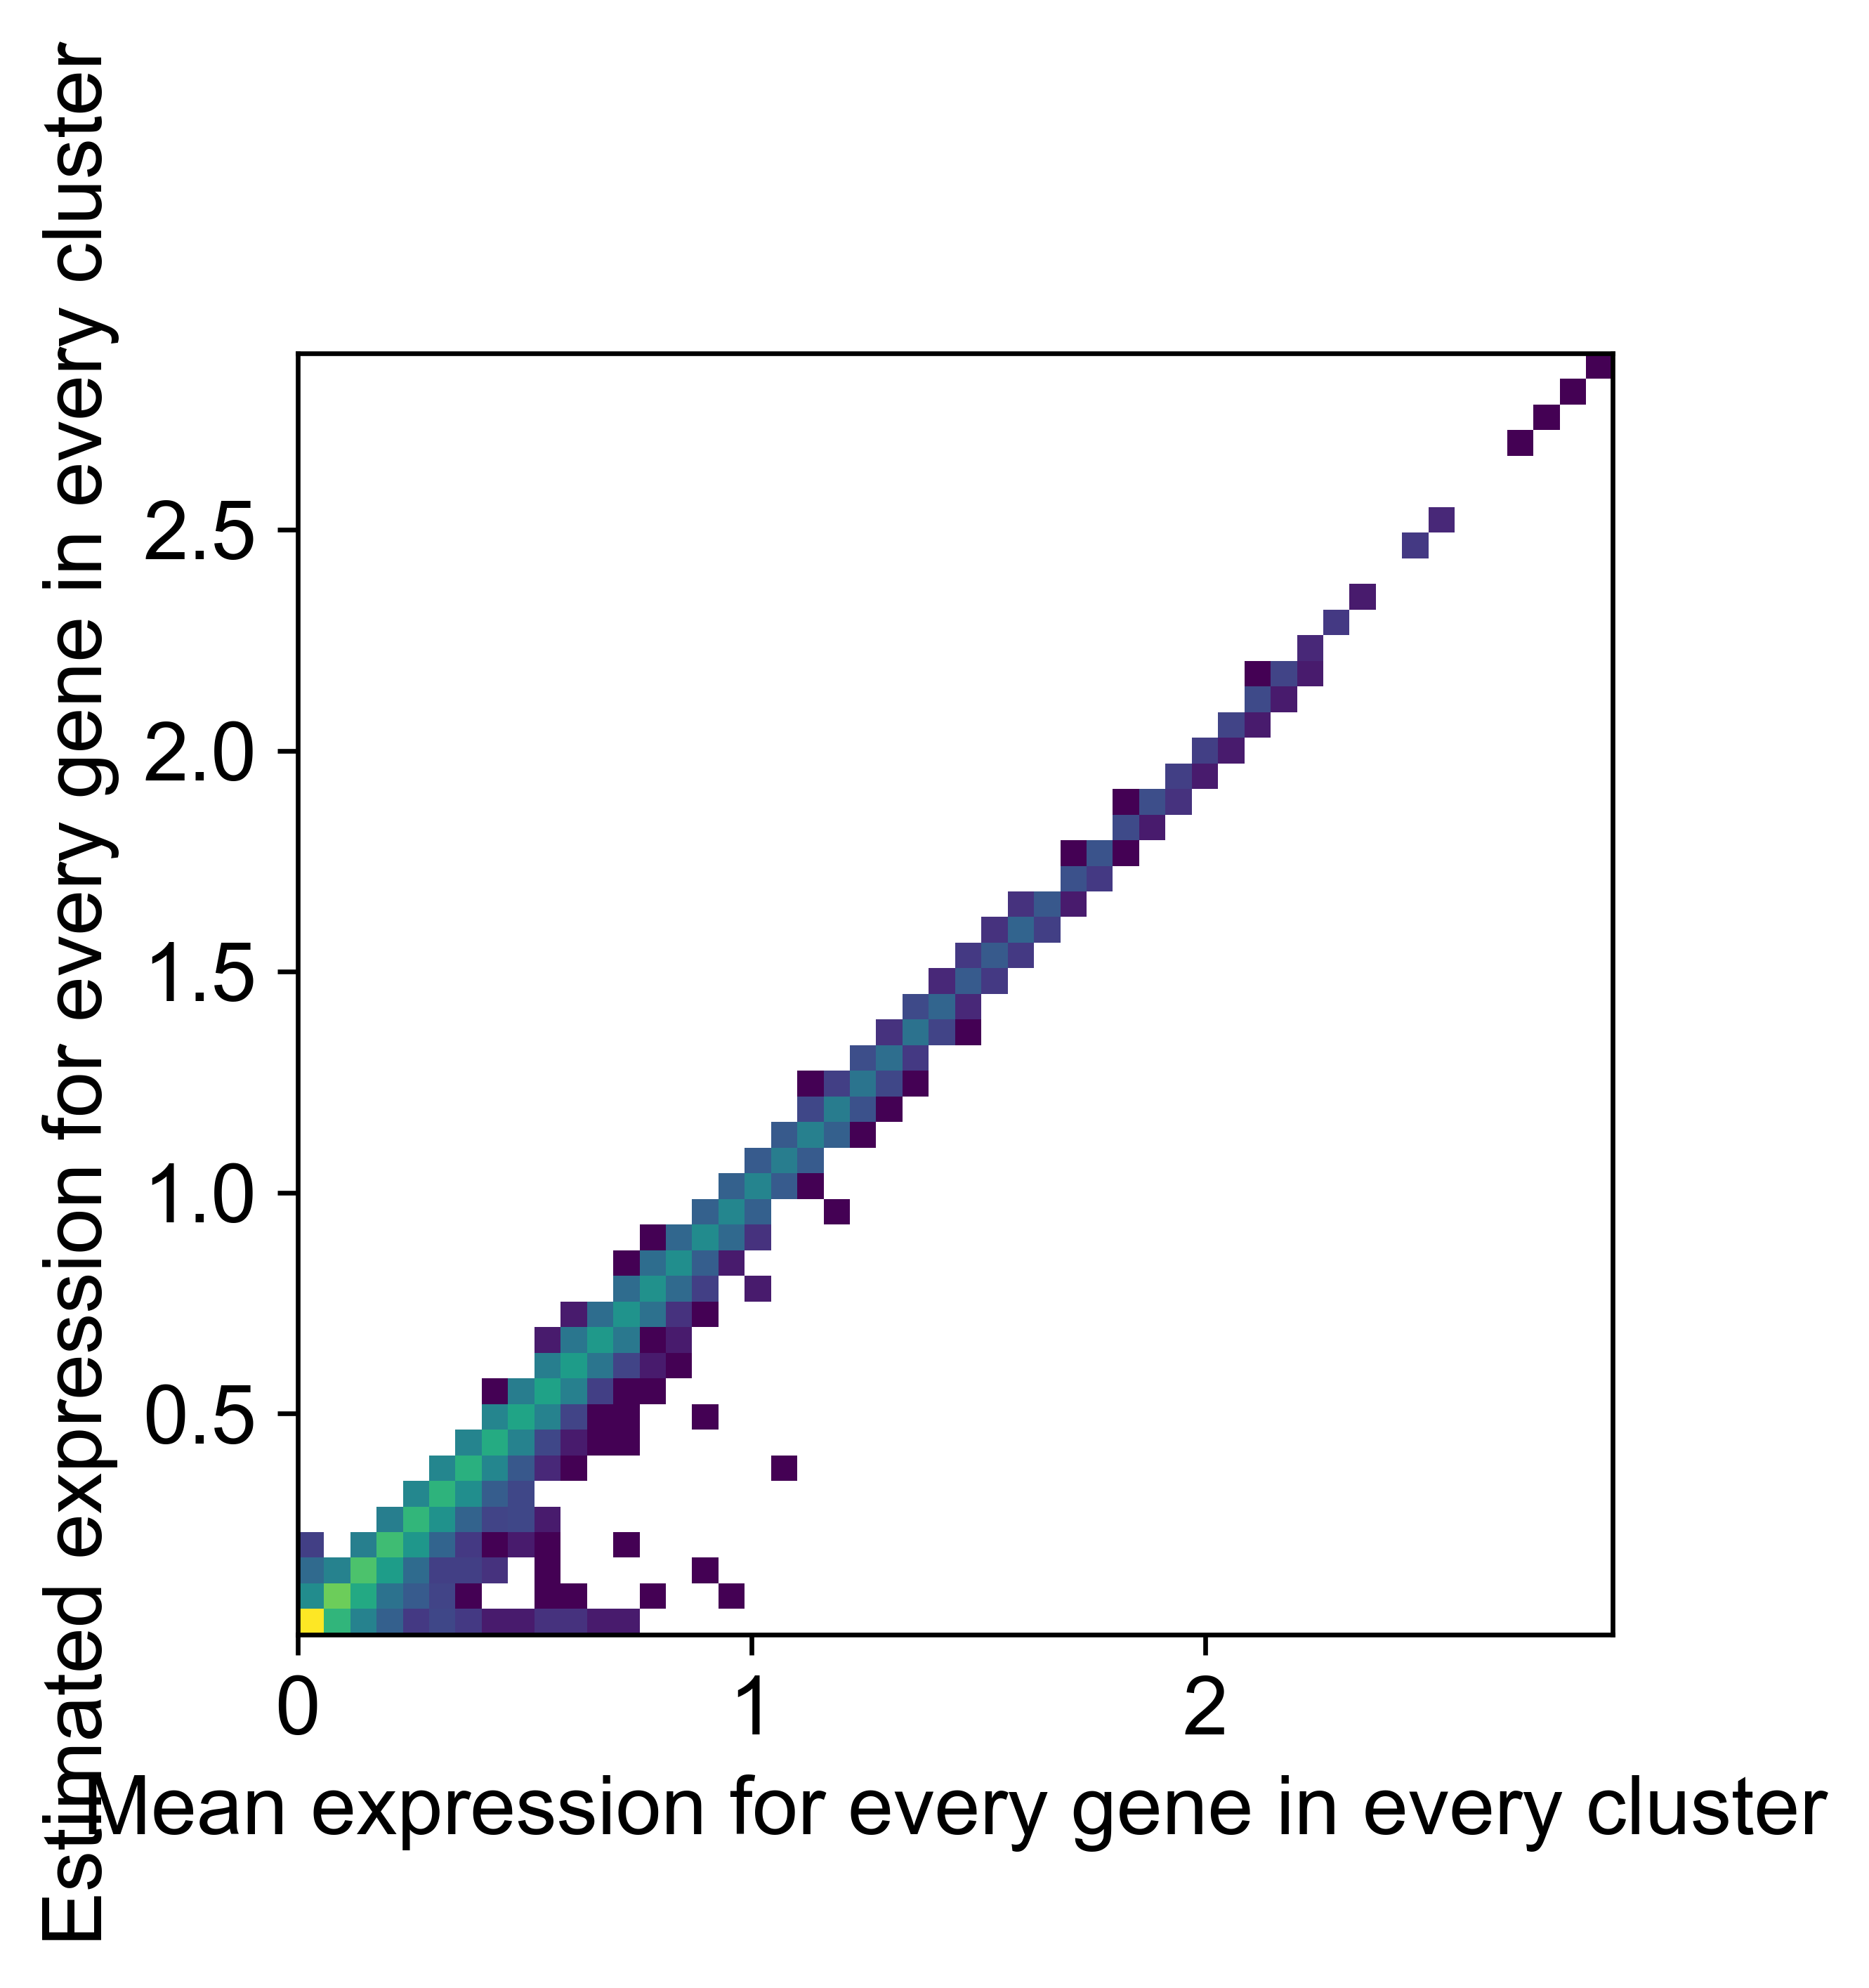

In [33]:
mod.plot_QC()

In [34]:
ref_run_name2 = f'{results_folder}/regression_model'
# The model can be loaded later like this:
adata_file = f"{ref_run_name2}/sc.h5ad"
adata_sc = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name2}", adata_sc)

INFO     File /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/
         cell2location_1118_9combCT/regression_model/model.pt already downloaded             
INFO     Preparing underlying module for load                                                


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/343:   0%|                                       | 1/343 [00:00<03:24,  1.68it/s, v_num=1, elbo_train=1.62e+8]


In [35]:
adata_sc

AnnData object with n_obs × n_vars = 58253 × 2867
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'CellTypes', 'newCellTypes', 'newMainCellTypes', 'doublet_scores', 'n_genes', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'features', 'n_cells', 'nonz_mean'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    varm: 'means_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg', 'stds_per_cluster_mu_fg'

In [36]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_sc.varm.keys():
    inf_aver = adata_sc.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_sc.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_sc.uns['mod']['factor_names']
print(len(inf_aver))
inf_aver.iloc[0:5, :]

2867


,Endothelial,Fibroblast,Hair follicle,Keratinocyte,Lymphoid,Mast,Melanocyte,Myeloid,Pericyte & Smooth muscle,Schwann
features,,,,,,,,,,
A1BG,0.039766,1.898743,0.299339,0.015262,0.290909,0.168689,1.968584,0.380229,0.942067,1.831575
A2M,15.922318,0.589595,0.026212,0.002696,0.005266,0.008047,0.206267,0.946249,9.851678,0.258212
A4GALT,1.607772,1.225366,0.003349,0.000387,0.001654,0.001228,0.028621,0.038179,0.546694,0.284859
AADACL2,0.002005,0.008058,0.505069,0.739819,0.000623,0.000599,0.004188,0.000569,0.002187,0.013588
ABCA1,0.617974,2.385286,0.424387,0.590608,0.009399,0.548402,1.189099,4.713368,0.323594,0.965068


In [37]:
pd.DataFrame(inf_aver).to_csv(f"{ref_run_name2}/infer_signatures_sc_filter.csv")

## Load the ST-seq data 

In [4]:
print("\nDonor1_Skin")
Donor1_Skin=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P17401_1001/outs", library_id = "Donor1_Skin")
Donor1_Skin.var_names_make_unique()
print(len(Donor1_Skin.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor1_Skin/barcodes.csv", header = None)
print(len(barcodes))
Donor1_Skin = Donor1_Skin[Donor1_Skin.obs.index.isin(barcodes[0]),:]
print(Donor1_Skin)

print("\nDonor1_Wound1")
Donor1_Wound1=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P17401_1002/outs", library_id = "Donor1_Wound1")
Donor1_Wound1.var_names_make_unique()
print(len(Donor1_Wound1.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor1_Wound1/barcodes.csv", header = None)
print(len(barcodes))
Donor1_Wound1 = Donor1_Wound1[Donor1_Wound1.obs.index.isin(barcodes[0]),:]
print(Donor1_Wound1)

print("\nDonor1_Wound7")
Donor1_Wound7=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P17401_1003/outs", library_id = "Donor1_Wound7")
Donor1_Wound7.var_names_make_unique()
print(len(Donor1_Wound7.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor1_Wound7/barcodes.csv", header = None)
print(len(barcodes))
Donor1_Wound7 = Donor1_Wound7[Donor1_Wound7.obs.index.isin(barcodes[0]),:]
print(Donor1_Wound7)

print("\nDonor1_Wound30")
Donor1_Wound30=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P17401_1004/outs", library_id = "Donor1_Wound30")
Donor1_Wound30.var_names_make_unique()
print(len(Donor1_Wound30.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor1_Wound30/barcodes.csv", header = None)
print(len(barcodes))
Donor1_Wound30 = Donor1_Wound30[Donor1_Wound30.obs.index.isin(barcodes[0]),:]
print(Donor1_Wound30)


Donor1_Skin
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P17401_1001/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
1382
810
View of AnnData object with n_obs × n_vars = 810 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Donor1_Wound1
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P17401_1002/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
2050
1832
View of AnnData object with n_obs × n_vars = 1832 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Donor1_Wound7
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P17401_1003/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
1802
1689
View of AnnData object with n_obs × n_vars = 1689 × 36600
    obs: 'in_tissue', 'array_row'

In [6]:
print("\nDonor2_Skin")
Donor2_Skin=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_101/outs", library_id = "Donor2_Skin")
Donor2_Skin.var_names_make_unique()
print(len(Donor2_Skin.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor2_Skin/barcodes.csv", header = None)
print(len(barcodes))
Donor2_Skin = Donor2_Skin[Donor2_Skin.obs.index.isin(barcodes[0]),:]
print(Donor2_Skin)

print("\nDonor2_Wound1")
Donor2_Wound1=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_102/outs", library_id = "Donor2_Wound1")
Donor2_Wound1.var_names_make_unique()
print(len(Donor2_Wound1.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor2_Wound1/barcodes.csv", header = None)
print(len(barcodes))
Donor2_Wound1 = Donor2_Wound1[Donor2_Wound1.obs.index.isin(barcodes[0]),:]
print(Donor2_Wound1)

print("\nDonor2_Wound7")
Donor2_Wound7=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_103/outs", library_id = "Donor2_Wound7")
Donor2_Wound7.var_names_make_unique()
print(len(Donor2_Wound7.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor2_Wound7/barcodes.csv", header = None)
print(len(barcodes))
Donor2_Wound7 = Donor2_Wound7[Donor2_Wound7.obs.index.isin(barcodes[0]),:]
print(Donor2_Wound7)

print("\nDonor2_Wound30")
Donor2_Wound30=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_104/outs", library_id = "Donor2_Wound30")
Donor2_Wound30.var_names_make_unique()
print(len(Donor2_Wound30.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor2_Wound30/barcodes.csv", header = None)
print(len(barcodes))
Donor2_Wound30 = Donor2_Wound30[Donor2_Wound30.obs.index.isin(barcodes[0]),:]
print(Donor2_Wound30)


Donor2_Skin
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_101/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
914
842
View of AnnData object with n_obs × n_vars = 842 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Donor2_Wound1
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_102/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
1901
1758
View of AnnData object with n_obs × n_vars = 1758 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Donor2_Wound7
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_103/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
1953
1606
View of AnnData object with n_obs × n_vars = 1606 × 36600
    obs: 'in_tissue', 'array_row', 'a

In [7]:
print("\nDonor3_Skin")
Donor3_Skin=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_105/outs", library_id = "Donor3_Skin")
Donor3_Skin.var_names_make_unique()
print(len(Donor3_Skin.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor3_Skin/barcodes.csv", header = None)
print(len(barcodes))
Donor3_Skin = Donor3_Skin[Donor3_Skin.obs.index.isin(barcodes[0]),:]
print(Donor3_Skin)

print("\nDonor3_Wound1")
Donor3_Wound1=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_106/outs", library_id = "Donor3_Wound1")
Donor3_Wound1.var_names_make_unique()
print(len(Donor3_Wound1.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor3_Wound1/barcodes.csv", header = None)
print(len(barcodes))
Donor3_Wound1 = Donor3_Wound1[Donor3_Wound1.obs.index.isin(barcodes[0]),:]
print(Donor3_Wound1)

print("\nDonor3_Wound7")
Donor3_Wound7=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_107/outs", library_id = "Donor3_Wound7")
Donor3_Wound7.var_names_make_unique()
print(len(Donor3_Wound7.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor3_Wound7/barcodes.csv", header = None)
print(len(barcodes))
Donor3_Wound7 = Donor3_Wound7[Donor3_Wound7.obs.index.isin(barcodes[0]),:]
print(Donor3_Wound7)

print("\nDonor3_Wound30")
Donor3_Wound30=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_108/outs", library_id = "Donor3_Wound30")
Donor3_Wound30.var_names_make_unique()
print(len(Donor3_Wound30.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor3_Wound30/barcodes.csv", header = None)
print(len(barcodes))
Donor3_Wound30 = Donor3_Wound30[Donor3_Wound30.obs.index.isin(barcodes[0]),:]
print(Donor3_Wound30)


Donor3_Skin
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_105/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
793
685
View of AnnData object with n_obs × n_vars = 685 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Donor3_Wound1
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_106/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
1507
1317
View of AnnData object with n_obs × n_vars = 1317 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Donor3_Wound7
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_107/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
1749
1537
View of AnnData object with n_obs × n_vars = 1537 × 36600
    obs: 'in_tissue', 'array_row', 'a

In [8]:
print("\nDonor4_Skin")
Donor4_Skin=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_109/outs", library_id = "Donor4_Skin")
Donor4_Skin.var_names_make_unique()
print(len(Donor4_Skin.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor4_Skin/barcodes.csv", header = None)
print(len(barcodes))
Donor4_Skin = Donor4_Skin[Donor4_Skin.obs.index.isin(barcodes[0]),:]
print(Donor4_Skin)

print("\nDonor4_Wound1")
Donor4_Wound1=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_110/outs", library_id = "Donor4_Wound1")
Donor4_Wound1.var_names_make_unique()
print(len(Donor4_Wound1.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor4_Wound1/barcodes.csv", header = None)
print(len(barcodes))
Donor4_Wound1 = Donor4_Wound1[Donor4_Wound1.obs.index.isin(barcodes[0]),:]
print(Donor4_Wound1)

print("\nDonor4_Wound7")
Donor4_Wound7=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_111/outs", library_id = "Donor4_Wound7")
Donor4_Wound7.var_names_make_unique()
print(len(Donor4_Wound7.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor4_Wound7/barcodes.csv", header = None)
print(len(barcodes))
Donor4_Wound7 = Donor4_Wound7[Donor4_Wound7.obs.index.isin(barcodes[0]),:]
print(Donor4_Wound7)

print("\nDonor4_Wound30")
Donor4_Wound30=sc.read_visium("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_112/outs", library_id = "Donor4_Wound30")
Donor4_Wound30.var_names_make_unique()
print(len(Donor4_Wound30.obs))
# read barcodes and filter spots
barcodes = pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/Donor4_Wound30/barcodes.csv", header = None)
print(len(barcodes))
Donor4_Wound30 = Donor4_Wound30[Donor4_Wound30.obs.index.isin(barcodes[0]),:]
print(Donor4_Wound30)


Donor4_Skin
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_109/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
880
740
View of AnnData object with n_obs × n_vars = 740 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Donor4_Wound1
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_110/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
1745
1608
View of AnnData object with n_obs × n_vars = 1608 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Donor4_Wound7
reading /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/00-spacerange_counts/P20063_111/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
1334
1212
View of AnnData object with n_obs × n_vars = 1212 × 36600
    obs: 'in_tissue', 'array_row', 'a

In [9]:
# To make sure that both images are included in the merged object, use uns_merge="unique"
# merge into one dataset
library_names = ["Donor1_Skin", "Donor1_Wound1", "Donor1_Wound7", "Donor1_Wound30",
                 "Donor2_Skin", "Donor2_Wound1", "Donor2_Wound7", "Donor2_Wound30",
                 "Donor3_Skin", "Donor3_Wound1", "Donor3_Wound7", "Donor3_Wound30",
                 "Donor4_Skin", "Donor4_Wound1", "Donor4_Wound7", "Donor4_Wound30"]

In [10]:
adata_vis = Donor1_Skin.concatenate(
    [Donor1_Wound1, Donor1_Wound7, Donor1_Wound30, 
     Donor2_Skin, Donor2_Wound1, Donor2_Wound7, Donor2_Wound30, 
     Donor3_Skin, Donor3_Wound1, Donor3_Wound7, Donor3_Wound30,
     Donor4_Skin, Donor4_Wound1, Donor4_Wound7, Donor4_Wound30],
    batch_key="library_id",
    uns_merge="unique",
    batch_categories=library_names
)

In [11]:
adata_vis

AnnData object with n_obs × n_vars = 22915 × 36600
    obs: 'in_tissue', 'array_row', 'array_col', 'library_id'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
adata_vis.obs

,in_tissue,array_row,array_col,library_id
AAACAAGTATCTCCCA-1-Donor1_Skin,1,50,102,Donor1_Skin
AAACATTTCCCGGATT-1-Donor1_Skin,1,61,97,Donor1_Skin
AAACCTAAGCAGCCGG-1-Donor1_Skin,1,65,83,Donor1_Skin
AAACGAGACGGTTGAT-1-Donor1_Skin,1,35,79,Donor1_Skin
AAACGGGCGTACGGGT-1-Donor1_Skin,1,65,91,Donor1_Skin
...,...,...,...,...
TTGTGTTTCCCGAAAG-1-Donor4_Wound30,1,51,59,Donor4_Wound30
TTGTTAGCAAATTCGA-1-Donor4_Wound30,1,22,42,Donor4_Wound30
TTGTTCAGTGTGCTAC-1-Donor4_Wound30,1,24,64,Donor4_Wound30
TTGTTGTGTGTCAAGA-1-Donor4_Wound30,1,31,77,Donor4_Wound30


In [12]:
# output the original name of each spot (by scanpy)
df=pd.DataFrame(adata_vis.obs.index)
df.to_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/sc_readvisium_barcode_ori.csv")

In [14]:
# change the name keeping consistent to Seurat
bar=pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/inputs/st_metadata.csv")

In [17]:
adata_vis.obs.index=bar['barcode'].tolist()

In [18]:
adata_vis.obs

,in_tissue,array_row,array_col,library_id
Donor1_Skin_AAACAAGTATCTCCCA-1,1,50,102,Donor1_Skin
Donor1_Skin_AAACATTTCCCGGATT-1,1,61,97,Donor1_Skin
Donor1_Skin_AAACCTAAGCAGCCGG-1,1,65,83,Donor1_Skin
Donor1_Skin_AAACGAGACGGTTGAT-1,1,35,79,Donor1_Skin
Donor1_Skin_AAACGGGCGTACGGGT-1,1,65,91,Donor1_Skin
...,...,...,...,...
Donor4_Wound30_TTGTGTTTCCCGAAAG-1,1,51,59,Donor4_Wound30
Donor4_Wound30_TTGTTAGCAAATTCGA-1,1,22,42,Donor4_Wound30
Donor4_Wound30_TTGTTCAGTGTGCTAC-1,1,24,64,Donor4_Wound30
Donor4_Wound30_TTGTTGTGTGTCAAGA-1,1,31,77,Donor4_Wound30


In [20]:
adata_vis

AnnData object with n_obs × n_vars = 22915 × 36600
    obs: 'in_tissue', 'array_row', 'array_col', 'library_id'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [144]:
# read the gene signature keeping consistent to Seurat
#varG=pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/inputs/st_features.csv")

In [145]:
#adata_vis=adata_vis[:, adata_vis.var.index.isin(varG['gene'])]

In [146]:
#pd.DataFrame(adata_vis.var.index.isin(varG['gene'])).value_counts()

True    36545
dtype: int64

In [154]:
#adata_vis.obs

,in_tissue,array_row,array_col,library_id
Donor1_Skin_AAACAAGTATCTCCCA-1,1,50,102,Donor1_Skin
Donor1_Skin_AAACATTTCCCGGATT-1,1,61,97,Donor1_Skin
Donor1_Skin_AAACCTAAGCAGCCGG-1,1,65,83,Donor1_Skin
Donor1_Skin_AAACGAGACGGTTGAT-1,1,35,79,Donor1_Skin
Donor1_Skin_AAACGGGCGTACGGGT-1,1,65,91,Donor1_Skin
...,...,...,...,...
Donor4_Wound30_TTGTGTTTCCCGAAAG-1,1,51,59,Donor4_Wound30
Donor4_Wound30_TTGTTAGCAAATTCGA-1,1,22,42,Donor4_Wound30
Donor4_Wound30_TTGTTCAGTGTGCTAC-1,1,24,64,Donor4_Wound30
Donor4_Wound30_TTGTTGTGTGTCAAGA-1,1,31,77,Donor4_Wound30


#### Optional 

In [159]:
# add the metadata from Seurat
#metadata=pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/inputs/st_metadata.csv")

In [160]:
#metadata

,num,barcode,orig.ident,nCount_Spatial,nFeature_Spatial,Patient,Donor,Gender,Age,Seq_Batch,...,percent.mt,percent.ribo,percent.hb,percent.malat1,nFeature_noMT,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,individual_clust
0,0,Donor1_Skin_AAACAAGTATCTCCCA-1,P17401_1001,1349,780,PWH19,Donor1,Male,24,1,...,7.093664,11.776860,0.000000,0.000000,780,1188,775,2,2,3
1,1,Donor1_Skin_AAACATTTCCCGGATT-1,P17401_1001,649,420,PWH19,Donor1,Male,24,1,...,3.129657,9.985097,0.149031,0.000000,421,766,417,6,6,3
2,2,Donor1_Skin_AAACCTAAGCAGCCGG-1,P17401_1001,11039,3535,PWH19,Donor1,Male,24,1,...,14.962267,10.734637,0.030802,0.077006,3537,1273,585,3,3,8
3,3,Donor1_Skin_AAACGAGACGGTTGAT-1,P17401_1001,941,631,PWH19,Donor1,Male,24,1,...,3.881512,12.053115,0.000000,0.306435,631,938,628,6,6,3
4,4,Donor1_Skin_AAACGGGCGTACGGGT-1,P17401_1001,291,233,PWH19,Donor1,Male,24,1,...,5.519481,12.012987,0.000000,0.000000,233,705,299,14,14,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24707,24707,Donor4_Wound30_TTGTGTTTCCCGAAAG-1,P20063_112,2274,1188,PWH27,Donor4,Female,22,3,...,2.361529,8.630313,0.000000,0.901675,1188,2084,1184,2,2,11
24708,24708,Donor4_Wound30_TTGTTAGCAAATTCGA-1,P20063_112,5782,2164,PWH27,Donor4,Female,22,3,...,3.311037,9.765886,0.000000,0.250836,2164,2013,1087,6,6,10
24709,24709,Donor4_Wound30_TTGTTCAGTGTGCTAC-1,P20063_112,4630,2034,PWH27,Donor4,Female,22,3,...,2.608330,11.442995,0.000000,0.420698,2034,2571,1735,19,19,10
24710,24710,Donor4_Wound30_TTGTTGTGTGTCAAGA-1,P20063_112,445,345,PWH27,Donor4,Female,22,3,...,3.050109,6.971678,0.000000,1.307190,345,1254,454,1,1,1


In [167]:
#adata_vis.obs['orig.ident']=metadata['orig.ident'].astype('category').tolist()
#adata_vis.obs['seurat_clusters']=metadata['seurat_clusters'].astype('category').tolist()

In [19]:
#adata_vis.obs

In [21]:
# Save anndata object with results
adata_vis.write("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_1118_9combCT/STseq_scanpy_cleanSpots.h5ad")

In [22]:
#adata_vis=sc.read("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/ST-seq_scanpy0519.h5ad")

## Prepare the ST and SC data 

In [19]:
inf_aver=pd.read_csv("/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/deconvolution/cell2location_deconv/regression_model/mg_mkRef_0518/infer_signatures_sc_filter_0518.csv", index_col=0)

In [20]:
inf_aver

,Basal-I,Basal-II,Basal-III,DC,DC-LAMP,Dermal-DC,FB-I,FB-II,FB-III,FB-IV,...,Mono-Mac,NK-cell,PC-vSMC,Plasma_B-cell,Schwann,Spinous-I,Spinous-II,Spinous-III,Th,VE
features,,,,,,,,,,,,,,,,,,,,,
A2M,0.009046,0.041211,0.007698,0.104078,0.623872,0.536916,0.412145,1.021916,0.157625,0.915098,...,1.571760,0.012550,9.851009,0.048577,0.306549,0.002793,0.243344,0.022114,0.002990,19.086432
A2ML1,0.014517,0.117990,0.040825,0.005782,0.005157,0.002851,0.008580,0.002021,0.002604,0.086758,...,0.006707,0.003015,0.002519,0.004516,0.003976,0.427887,0.098928,0.452145,0.002049,0.002983
A4GALT,0.002045,0.003198,0.003885,0.039561,0.008222,0.030567,1.232945,1.152572,1.470050,0.716048,...,0.046989,0.006547,0.518133,0.014346,0.300569,0.002138,0.004011,0.006390,0.001952,1.680630
AADACL2,0.004074,0.230671,0.008097,0.003930,0.007689,0.004015,0.011290,0.006369,0.022672,0.089685,...,0.001644,0.001744,0.007907,0.006739,0.013065,0.842582,0.312644,0.473162,0.003501,0.003531
AAMDC,0.959330,1.867081,1.003184,0.174252,0.219783,0.204024,1.493657,0.725992,0.828844,1.445838,...,0.180041,0.071920,0.644437,0.114645,2.017618,2.180160,1.796503,0.939847,0.056892,0.868393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF385D,0.002769,0.003775,0.003703,0.011632,0.008439,0.002339,0.483713,0.598148,0.893289,0.406083,...,0.003368,0.004641,0.149784,0.023842,0.097107,0.003416,0.005838,0.052590,0.001946,5.749532
ZNF395,0.928732,0.831852,0.983508,0.051885,0.015221,0.013849,0.418531,0.264556,0.486216,0.446688,...,0.115430,0.038892,0.170166,0.044578,0.175406,0.523695,0.669925,0.403347,0.047041,0.306333
ZNF750,0.007807,1.008470,0.202386,0.021770,0.028135,0.008028,0.026949,0.010001,0.003644,0.334240,...,0.019315,0.008112,0.018010,0.019699,0.051275,2.541185,1.532685,2.496400,0.003643,0.060435


In [23]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
print(len(intersect))
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

2014


## Cell2location mapping 

In [24]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="library_id")

In [25]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, 
    cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=20,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
)

In [26]:
mod.view_anndata_setup(adata_vis)

Anndata setup with scvi-tools version 0.16.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'library_id',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 24712 │
│          n_vars          │ 2014  │
│         n_batch          │  16   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                       batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['library_id'] │  Donor1_Skin   │          0          │
│                         │ Donor1_Wound1  │          1          │
│                         │ Donor1_Wound7  │          2          │
│                         │ Donor1_Wound30 │          3          │
│                         │  Donor2_Skin   │          4          │
│                         │ Donor2_Wound1  │          5          │
│                         │ Donor2_Wound7  │          6          │
│                         │ Donor2_Wound30 │          7          │
│                         │  Donor3_Skin   │          8          │
│                         │ Donor3_Wound1  │          9          │
│                         │ Donor3_Wound7  │         10          │
│                         │ Donor3_Wound30 │         11          │
│                         │  Donor4_Skin   │         12          │
│                         │ Donor4_Wound1  │         13          │
│                         │ Donor4_Wound7  │         14          │
│                         │ Donor4_Wound30 │         15          │
└─────────────────────────┴────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 2/30000:   0%|                                | 1/30000 [00:03<31:14:06,  3.75s/it, v_num=1, elbo_train=6.07e+7]

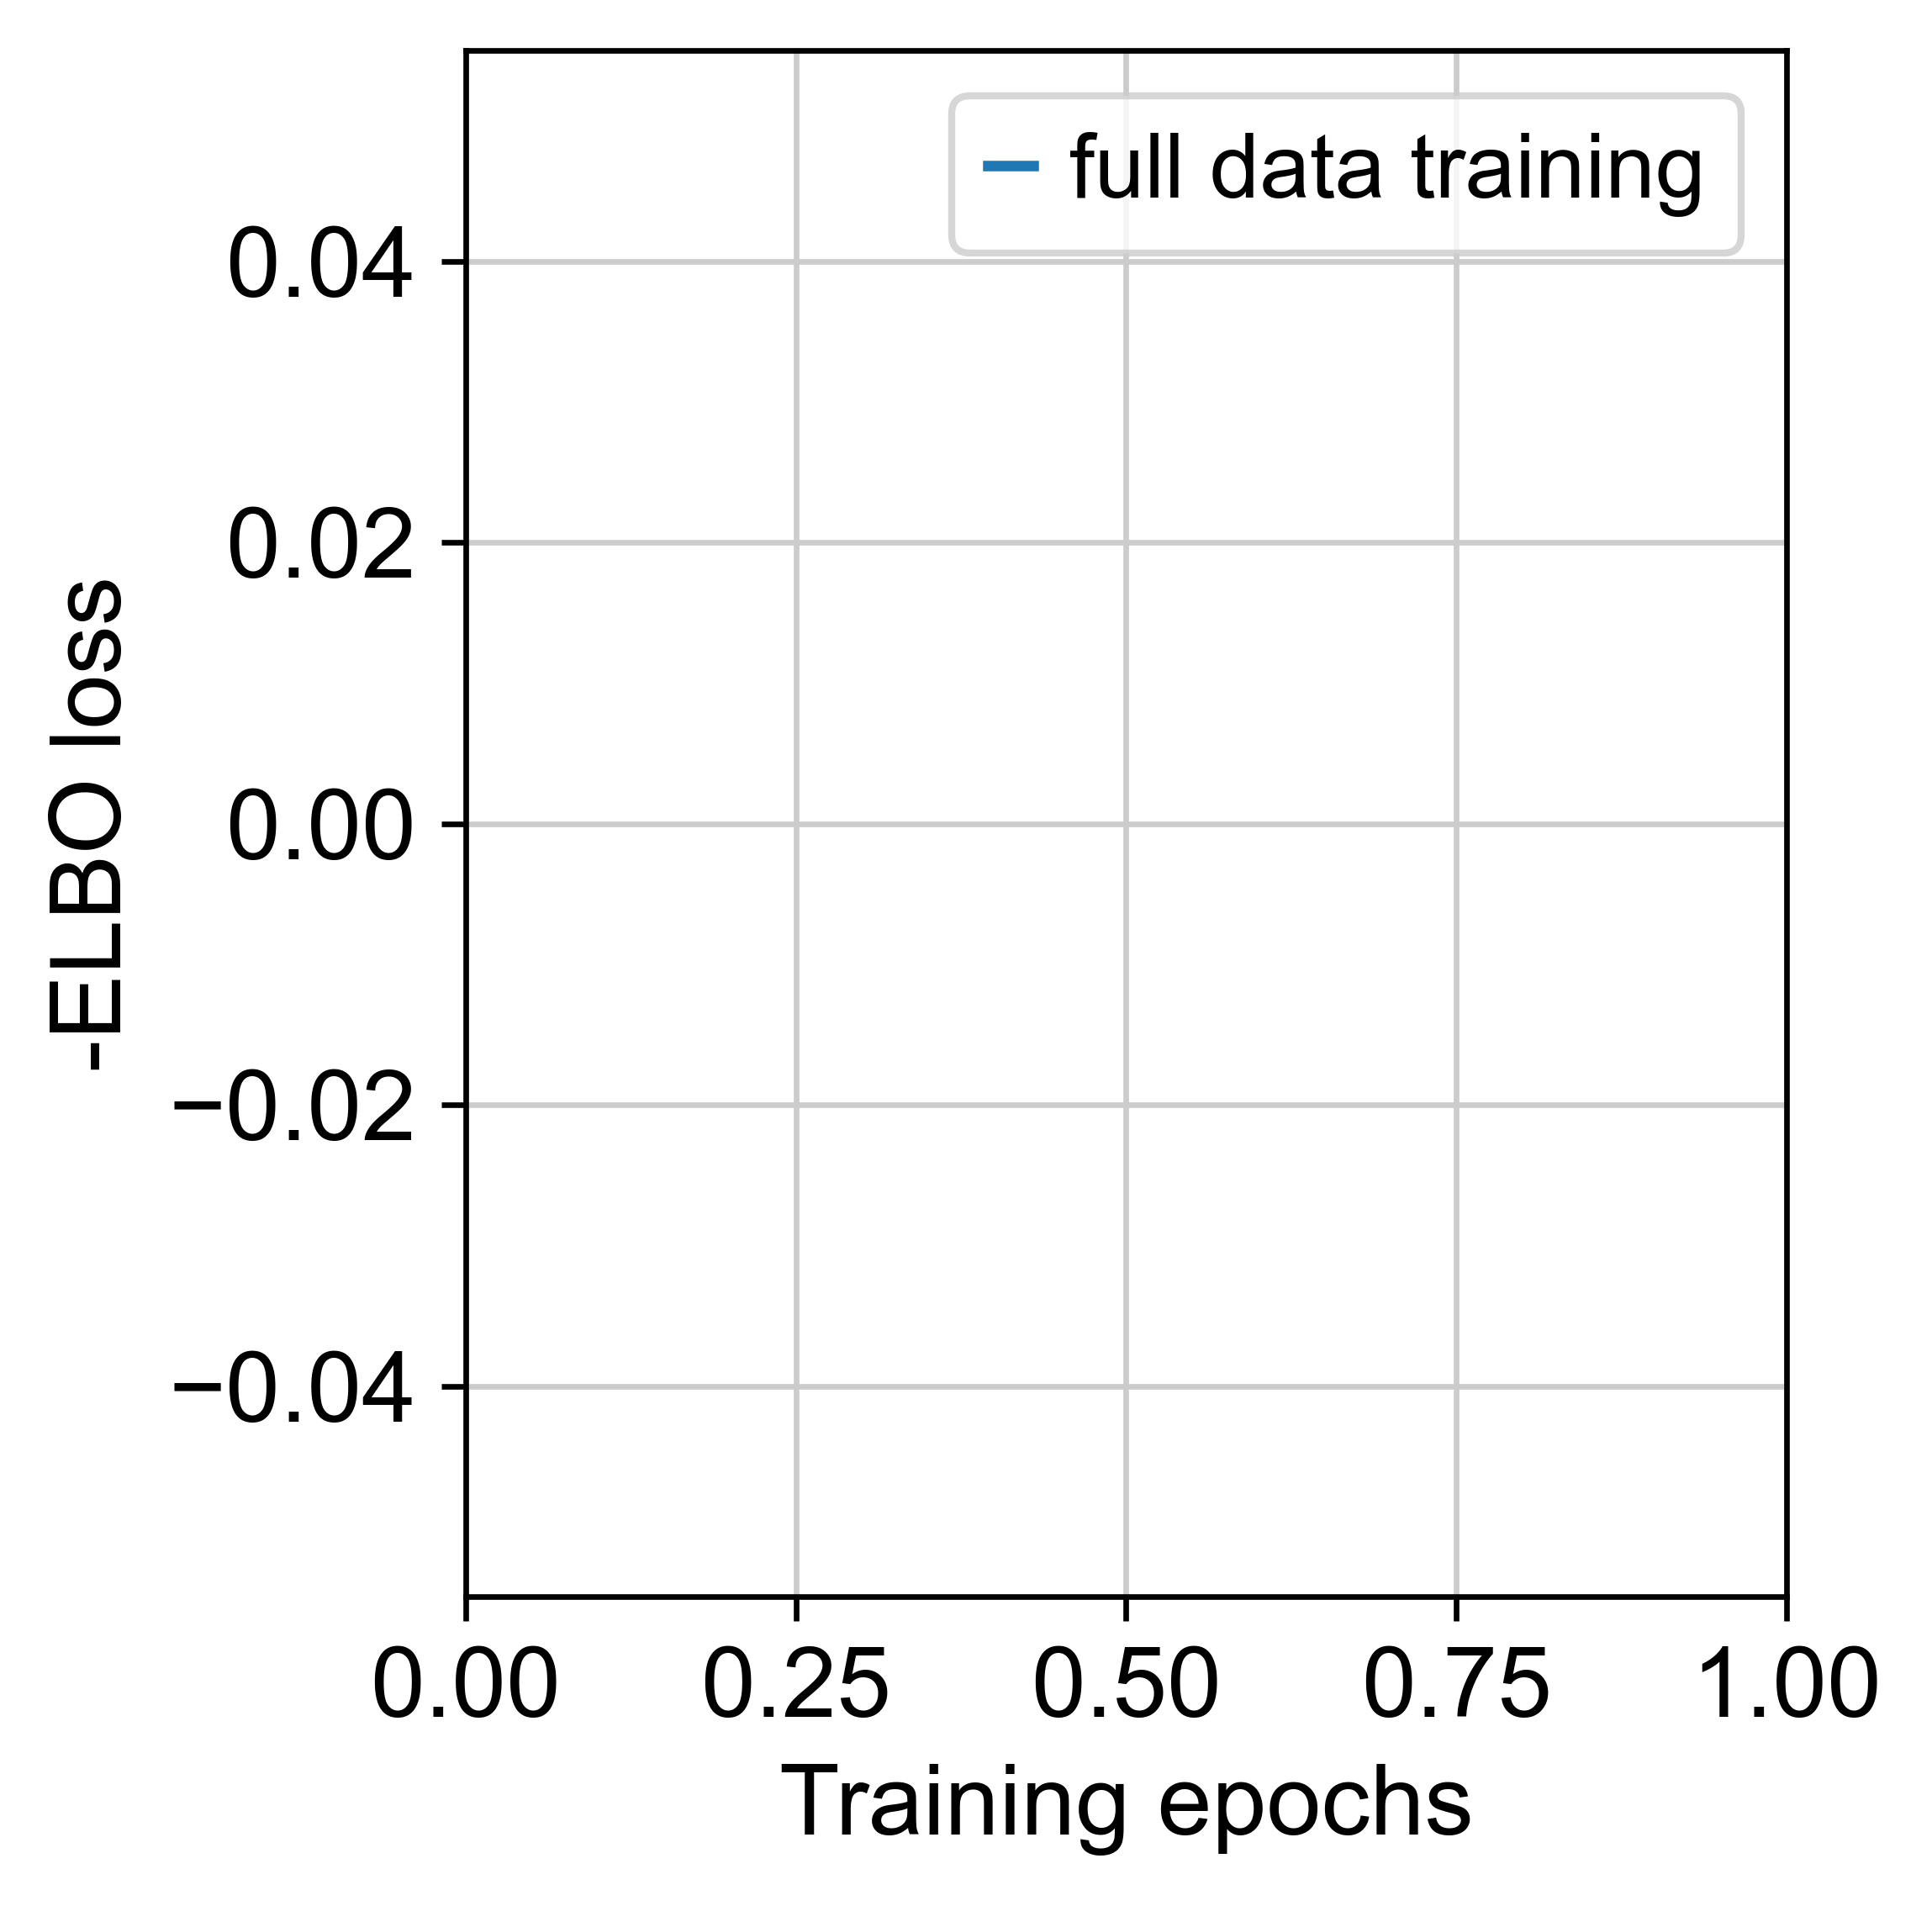

In [177]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False)

# plot ELBO loss history during training, removing first 1000 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{run_name}/st.h5ad"
adata_vis.write(adata_file)
adata_file

In [ ]:
# The model can be loaded later like this:
mod2 = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)
adata_file = f"{run_name}/st.h5ad"
adata_vis = sc.read_h5ad(adata_file)

In [ ]:
# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
#mod.plot_QC()
adata_vis

In [ ]:
fig = mod.plot_spatial_QC_across_batches()

In [ ]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                         'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [ ]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['T_CD4+_naive', 'B_naive', 'FDC']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

In [ ]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

In [ ]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

In [ ]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

In [ ]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

In [ ]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

In [ ]:
# Look at cell type specific expression in spatial coordinates,
# Here we highlight CD3D, pan T-cell marker expressed by
# 2 subtypes of T cells in distinct locations but not expressed by co-located B cells
ctypes = ['T_CD4+_TfH_GC', 'T_CD4+_naive', 'B_GC_LZ']
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);

In [ ]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

In [ ]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, use_gpu = True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');

In [3]:
import os

In [4]:
outdir = '/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/cell2location_deconv/tmp'
model_dir = os.path.join(outdir,"model")

In [5]:
model_dir

'/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/cell2location_deconv/tmp/model'

In [6]:
adata_path =  os.path.join(outdir,"adata.h5ad")
#sc_model.adata.write_h5ad(adata_path)

In [10]:
ref_run_name = '/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/stereoscope_deconv/regression_model'
print(f"{ref_run_name}")
print(os.path.join(f"{ref_run_name}","sc.h5ad"))

/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/stereoscope_deconv/regression_model
/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/stereoscope_deconv/regression_model/sc.h5ad


In [ ]:
cell2location.utils.list_imported_modules()